In [1]:
%load_ext autoreload
%autoreload 2
%run ./initializer

Added the path (/Users/rik/Documents/VU/DMT/DataMiningTechniquesA1) to sys.path


In [2]:
import torch
import torch.nn as nn
import optuna
from sklearn.model_selection import train_test_split
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt

from data_loading import DataPreprocessor
from mood_RNN_classifier import RNNClassifier, MoodDataset, OrdinalLabelSmoothingLoss, objective, train_epoch, train_final_model, evaluate, predict, plot_mood_predictions
from torch.utils.data import DataLoader

/Users/rik/Documents/VU/DMT/DataMiningTechniquesA1/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
data_loader = DataPreprocessor()
train_df_split, val_df_split, test_df = data_loader.load_and_preprocess_data("1d", 0.5, 1)

Removed 24 outliers from 1002 observations. Percentage: 2.40%


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assume train_df and test_df are loaded and preprocessed
id_map = {id_: idx for idx, id_ in enumerate(train_df_split['id'].unique())}
input_dim = train_df_split.drop(columns=['id', 'mood', 'date']).shape[1]
id_count = len(id_map)
output_dim = train_df_split['mood'].max() + 1

In [6]:
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, train_df_split, val_df_split, id_map, input_dim, id_count, output_dim, device), n_trials=200)

best_params = study.best_params
print("Best hyperparams:", best_params)

[I 2025-04-19 18:56:48,122] A new study created in memory with name: no-name-2427b8a8-c6af-4429-9c77-8d56432f230e
[I 2025-04-19 18:56:53,042] Trial 0 finished with value: 0.5048529823919884 and parameters: {'hidden_dim': 93, 'id_embed_dim': 5, 'lr': 0.00028867285835867815, 'batch_size': 64, 'alpha': 0.13017570799659403}. Best is trial 0 with value: 0.5048529823919884.
[I 2025-04-19 18:56:53,296] Trial 1 finished with value: 0.4159012647499715 and parameters: {'hidden_dim': 65, 'id_embed_dim': 10, 'lr': 0.006649848901327181, 'batch_size': 32, 'alpha': 0.2673661350003736}. Best is trial 1 with value: 0.4159012647499715.
[I 2025-04-19 18:56:53,426] Trial 2 finished with value: 0.19989992095563644 and parameters: {'hidden_dim': 76, 'id_embed_dim': 5, 'lr': 0.0005573336571753028, 'batch_size': 128, 'alpha': 0.03022474133374591}. Best is trial 2 with value: 0.19989992095563644.
[I 2025-04-19 18:56:53,724] Trial 3 finished with value: 0.263832452153801 and parameters: {'hidden_dim': 125, 'id_

Best hyperparams: {'hidden_dim': 40, 'id_embed_dim': 8, 'lr': 0.001716668218424835, 'batch_size': 32, 'alpha': 0.010593412705517707}


In [9]:
# Final model
model = RNNClassifier(
    input_dim=input_dim,
    hidden_dim=best_params['hidden_dim'],
    id_count=id_count,
    id_embed_dim=best_params['id_embed_dim'],
    output_dim=output_dim
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'])
criterion = OrdinalLabelSmoothingLoss(num_classes=output_dim, alpha=best_params['alpha'])

train_loader = DataLoader(MoodDataset(train_df_split, id_map), batch_size=best_params['batch_size'], shuffle=True)
val_loader = DataLoader(MoodDataset(val_df_split, id_map), batch_size=best_params['batch_size'])

In [10]:
model = train_final_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=1000)


Epoch 1: train loss = 0.0979, val loss = 0.0664
Epoch 2: train loss = 0.0421, val loss = 0.0256
Epoch 3: train loss = 0.0177, val loss = 0.0166
Epoch 4: train loss = 0.0127, val loss = 0.0148
Epoch 5: train loss = 0.0112, val loss = 0.0138
Epoch 6: train loss = 0.0104, val loss = 0.0134
Epoch 7: train loss = 0.0099, val loss = 0.0131
Epoch 8: train loss = 0.0094, val loss = 0.0130
Epoch 9: train loss = 0.0089, val loss = 0.0131
Epoch 10: train loss = 0.0086, val loss = 0.0122
Epoch 11: train loss = 0.0083, val loss = 0.0120
Epoch 12: train loss = 0.0078, val loss = 0.0118
Epoch 13: train loss = 0.0075, val loss = 0.0121
Epoch 14: train loss = 0.0073, val loss = 0.0123
Epoch 15: train loss = 0.0070, val loss = 0.0124
Epoch 16: train loss = 0.0067, val loss = 0.0122
Epoch 17: train loss = 0.0066, val loss = 0.0119
Epoch 18: train loss = 0.0065, val loss = 0.0120
Epoch 19: train loss = 0.0063, val loss = 0.0128
Epoch 20: train loss = 0.0062, val loss = 0.0124
Epoch 21: train loss = 0.0060

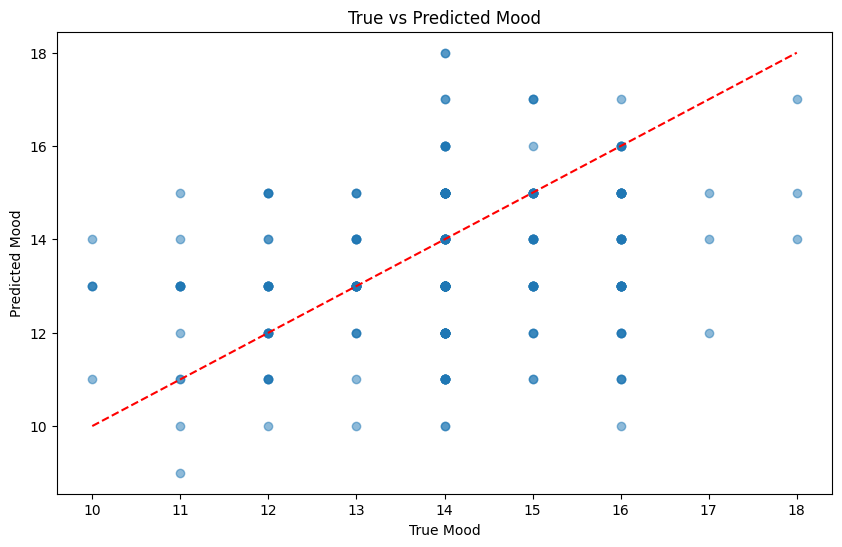

In [16]:
plot_mood_predictions(model, val_loader, device)

In [12]:
from mood_RNN_classifier import get_accuracy_rate
accuracy = get_accuracy_rate(model, val_loader, device)

Accuracy: 0.1917


In [13]:
# Run predictions on test_df
test_predictions = predict(model, test_df, id_map, device)

# Attach predictions to test_df
test_df_with_preds = test_df.copy()
test_df_with_preds['predicted_mood_class'] = test_predictions

# Optional: save to CSV or examine
print(test_df_with_preds[['id', 'predicted_mood_class']])

         id  predicted_mood_class
0   AS14.01                    14
1   AS14.02                    14
2   AS14.03                    12
3   AS14.05                    10
4   AS14.06                    11
5   AS14.07                    10
6   AS14.08                    12
7   AS14.09                    11
8   AS14.12                    10
9   AS14.13                    14
10  AS14.14                    15
11  AS14.15                    13
12  AS14.16                    11
13  AS14.17                    13
14  AS14.19                    11
15  AS14.20                    13
16  AS14.23                    16
17  AS14.24                    12
18  AS14.25                    12
19  AS14.26                    13
20  AS14.27                    13
21  AS14.28                    15
22  AS14.29                    14
23  AS14.30                    12
24  AS14.31                    15
25  AS14.32                    15
26  AS14.33                    14
